In [1]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [3]:
project = 'kolmogorov'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = False
latent_dim = 50

In [ ]:
u1 = np.load(f'{project_root}/data/{project}/u1.npy') 
u2 = np.load(f'{project_root}/data/{project}/u2.npy')
nt, n1, n2 = u1.shape

X, scaler = transform_data_for_AE(u1,u2)
X_flat = X.reshape(X.shape[0], -1)

print(f"Data shape: {X.shape}, Flat shape: {X_flat.shape}")

Data shape: (20000, 2, 64, 64), Flat shape: (20000, 8192)


In [6]:
# === Consistent train/val/test split ===
train_idx, val_idx, test_idx = split_indices(nt, split=(0.3, 0.2, 0.5))

X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

X_train_flat = X_flat[train_idx]
X_val_flat = X_flat[val_idx]
X_test_flat = X_flat[test_idx]

print(f"Train flat shape: {X_train_flat.shape}, Val flat shape: {X_val_flat.shape}, Test flat shape: {X_test_flat.shape}")

Train shape: (6000, 2, 64, 64), Val shape: (4000, 2, 64, 64), Test shape: (10000, 2, 64, 64)
Train flat shape: (6000, 8192), Val flat shape: (4000, 8192), Test flat shape: (10000, 8192)


In [ ]:
# === PCA Model ===
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/pca_model.pkl'):
    pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_model.pkl')
else:
    pca = PCA_AE(n_components=latent_dim)
    pca.train(X_train_flat)
    pca.save(f'{project_root}/src/models/checkpoints/{project}/pca_model.pkl')

Epoch 1/1000 - Train Loss: 0.4568 - Val Loss: 0.1587
Epoch 2/1000 - Train Loss: 0.1584 - Val Loss: 0.1331
Epoch 3/1000 - Train Loss: 0.1429 - Val Loss: 0.1253
Epoch 4/1000 - Train Loss: 0.1362 - Val Loss: 0.1207
Epoch 5/1000 - Train Loss: 0.1318 - Val Loss: 0.1195
Epoch 6/1000 - Train Loss: 0.1280 - Val Loss: 0.1118
Epoch 7/1000 - Train Loss: 0.1225 - Val Loss: 0.1071
Epoch 8/1000 - Train Loss: 0.1177 - Val Loss: 0.1022
Epoch 9/1000 - Train Loss: 0.1129 - Val Loss: 0.0977
Epoch 10/1000 - Train Loss: 0.1087 - Val Loss: 0.0943
Epoch 11/1000 - Train Loss: 0.1056 - Val Loss: 0.0918
Epoch 12/1000 - Train Loss: 0.1032 - Val Loss: 0.0894
Epoch 13/1000 - Train Loss: 0.1010 - Val Loss: 0.0875
Epoch 14/1000 - Train Loss: 0.0985 - Val Loss: 0.0863
Epoch 15/1000 - Train Loss: 0.0956 - Val Loss: 0.0837
Epoch 16/1000 - Train Loss: 0.0930 - Val Loss: 0.0784
Epoch 17/1000 - Train Loss: 0.0914 - Val Loss: 0.0767
Epoch 18/1000 - Train Loss: 0.0891 - Val Loss: 0.0756
Epoch 19/1000 - Train Loss: 0.0864 - 

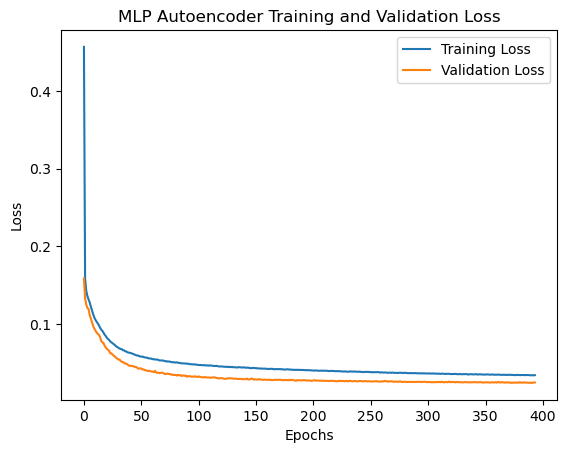

In [ ]:
# === MLP Autoencoder ===
# Prepare datasets and loaders

train_dataset = TensorDataset(torch.tensor(X_train_flat).float())
val_dataset = TensorDataset(torch.tensor(X_val_flat).float())
MLP_input_dim = X_train_flat.shape[1]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

mlp = MLP_AE(input_dim=MLP_input_dim, latent_dim=latent_dim)
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/mlp_model.pth'):
    mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_model.pth'))
    training_loss_mlp = np.load(f'{project_root}/src/models/checkpoints/{project}/mlp_training_loss.npy')
    validation_losses_mlp = np.load(f'{project_root}/src/models/checkpoints/{project}/mlp_validation_losses.npy')
else:
    training_loss_mlp, validation_losses_mlp = mlp.train_model(
                                                    train_loader=train_loader,
                                                    val_loader=val_loader,
                                                    device=device,
                                                    patience=20,
                                                    save_path=f'{project_root}/src/models/checkpoints/{project}/mlp_model.pth'
                                                )
    np.save(f'{project_root}/src/models/checkpoints/{project}/mlp_training_loss.npy', training_loss_mlp)
    np.save(f'{project_root}/src/models/checkpoints/{project}/mlp_validation_losses.npy', validation_losses_mlp)

plt.plot(training_loss_mlp, label='Training Loss')
plt.plot(validation_losses_mlp, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Autoencoder Training and Validation Loss')
plt.legend()

Epoch [1/1000], Training Loss: 0.2643, Validation Loss: 0.1153
Epoch [2/1000], Training Loss: 0.0954, Validation Loss: 0.0813
Epoch [3/1000], Training Loss: 0.0748, Validation Loss: 0.0689
Epoch [4/1000], Training Loss: 0.0642, Validation Loss: 0.0605
Epoch [5/1000], Training Loss: 0.0559, Validation Loss: 0.0520
Epoch [6/1000], Training Loss: 0.0484, Validation Loss: 0.0458
Epoch [7/1000], Training Loss: 0.0413, Validation Loss: 0.0397
Epoch [8/1000], Training Loss: 0.0368, Validation Loss: 0.0357
Epoch [9/1000], Training Loss: 0.0332, Validation Loss: 0.0325
Epoch [10/1000], Training Loss: 0.0306, Validation Loss: 0.0311
Epoch [11/1000], Training Loss: 0.0289, Validation Loss: 0.0298
Epoch [12/1000], Training Loss: 0.0270, Validation Loss: 0.0282
Epoch [13/1000], Training Loss: 0.0255, Validation Loss: 0.0259
Epoch [14/1000], Training Loss: 0.0241, Validation Loss: 0.0249
Epoch [15/1000], Training Loss: 0.0228, Validation Loss: 0.0255
Epoch [16/1000], Training Loss: 0.0219, Validatio

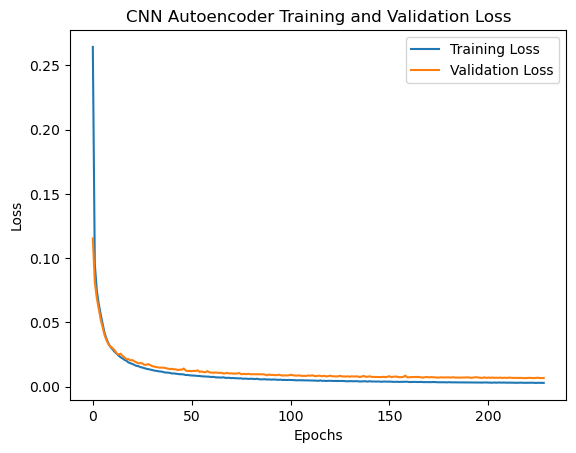

In [ ]:
# === CNN Autoencoder with mask-aware loss === #

# Create DataLoader from TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train).float())
val_dataset = TensorDataset(torch.tensor(X_val).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

# Instantiate CNN and train with the mask-aware loss
cnn = CNN_AE(latent_dim=latent_dim)
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth'):
    cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth'))
    training_losses_cnn = np.load(f'{project_root}/src/models/checkpoints/{project}/cnn_training_loss.npy')
    validation_losses_cnn = np.load(f'{project_root}/src/models/checkpoints/{project}/cnn_validation_losses.npy')
else:
    training_losses_cnn, validation_losses_cnn = cnn.train_model(
                                                    train_loader,
                                                    val_loader=val_loader,
                                                    device=device,
                                                    save_path=f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth')
    np.save(f'{project_root}/src/models/checkpoints/{project}/cnn_training_loss.npy', training_losses_cnn)
    np.save(f'{project_root}/src/models/checkpoints/{project}/cnn_validation_losses.npy', validation_losses_cnn)

plt.plot(training_losses_cnn, label='Training Loss')
plt.plot(validation_losses_cnn, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Autoencoder Training and Validation Loss')
plt.legend()